In [1]:
# Import library for load data
import ray
ray.init(num_cpus=20)
import modin.pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
import seaborn as sns
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from category_encoders import OrdinalEncoder
from numpy import genfromtxt
import sys
import csv
# Import deeplearning library
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms 
from torch.utils.data import Dataset
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import time
import os
import copy
import numpy as np 

2023-07-17 14:09:30,061	INFO worker.py:1636 -- Started a local Ray instance.
2023-07-17 14:09:34.984238: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Define CUDA device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
print('-------------ANALYZE DATASET-------------')
#Load dataset
print("Loading dataset, please wait .....")
train = pd.read_csv('/home/jun/CICIDS2019/TrainCIC2019.csv')
#test = pd.read_csv('/home/jun/CICIDS2019/TestCIC2019.csv')
print("DONE!")

-------------ANALYZE DATASET-------------
Loading dataset, please wait .....


DONE!


In [4]:
# The columns name of dataset is contain space, this function will strip it out (data = fix_columns_name(data))
def fix_columns_name(data):
    data.columns = [column_name.strip() for column_name in data.columns]
    return data

# Drop all string data in dataset (data = drop_non_numberic_columns(data))
def drop_non_numberic_columns(data):
    data.drop(['Unnamed: 0', 'Flow ID','Source IP','Destination IP', 'Timestamp', 'SimillarHTTP'], inplace=True, axis=1)
    return data

#Create a copy of pandas frame with dropped NaN and Inf value (data = drop_NaN(data))
def drop_NaN(data):
    dropped = data.copy(deep=True)
    dropped.replace([np.inf, -np.inf], np.nan, inplace=True)
    dropped.dropna(inplace=True)
    return dropped

# Return a dictionary of available labels and it number from dataset 'Label' column (labels_dict = available_lable(data))
# Input: dataset
# Output: 
# Traning dataset: {'Syn': 0, 'DrDoS_SNMP': 1, 'DrDoS_UDP': 2, 'DrDoS_DNS': 3, 'TFTP': 4, 'DrDoS_LDAP': 5, 'UDP-lag': 6, 'DrDoS_NTP': 7, 'DrDoS_MSSQL': 8, 'DrDoS_NetBIOS': 9, 'BENIGN': 10, 'WebDDoS': 11, 'DrDoS_SSDP': 12}
# Testing dataset {'Syn': 0, 'NetBIOS': 1, 'UDPLag': 2, 'LDAP': 3, 'MSSQL': 4, 'BENIGN': 5, 'Portmap': 6, 'UDP': 7} 
def available_label(data):
    data_labels = set(data['Label'])
    labels_dict = {}
    for i, label in enumerate(data_labels):
        labels_dict.update({label:i})
    return labels_dict

# Caculate flow labels number and return dictionary of {labels : count}
# train_flow_labels_count = flow_labels_count(data)
def flows_labels_count(data):
    labels = {}
    for flow_label in data['Label']:
        if flow_label in labels.keys():
            labels[flow_label] += 1
        else:
            labels[flow_label] = 0
    return labels

# Encoding labels to assigned number for learning
# data = encoding_lables('train', data)
def encoding_labels(dataset_type, data):
    if dataset_type == 'train':
        labels_num = {'Syn': 0, 'DrDoS_SNMP': 1, 'DrDoS_UDP': 2, 'DrDoS_DNS': 3, 'TFTP': 4, 'DrDoS_LDAP': 5, 'UDP-lag': 6, 'DrDoS_NTP': 7, 'DrDoS_MSSQL': 8, 'DrDoS_NetBIOS': 9, 'BENIGN': 10, 'WebDDoS': 11, 'DrDoS_SSDP': 12}
    elif dataset_type == 'test':
        labels_num = {'Syn': 0, 'NetBIOS': 9, 'UDPLag': 6, 'LDAP': 5, 'MSSQL': 8, 'BENIGN': 10, 'Portmap': 13, 'UDP': 6} 
    for label, number in labels_num.items():
        data['Label'] = data['Label'].replace(label, number)
    return data

# Ploting data
def data_plot(data):
    data_flow_labels_count = flows_labels_count(data)
    for flow_label, flow_number in data_flow_labels_count.items():
        print('Number of {} flow is: {}/{} ({:.2f})'.format(flow_label, flow_number, sum(data_flow_labels_count.values()), flow_number/sum(data_flow_labels_count.values())*100))
    #Create Flow Number based on label Figure
    data_flows_figure_num = plt.figure(figsize = (20, 5))
    # creating the bar plot
    plt.bar(data_flow_labels_count.keys(), data_flow_labels_count.values(), color ='red',
            width = 0.5)
    plt.xlabel("Flows Label")
    plt.ylabel("Number of FLows")
    plt.title("Flows label and number")
    plt.show()

In [5]:
# Fix columns name
train = fix_columns_name(train)
#test = fix_columns_name(test)

In [6]:
# Get dictionary of available labels in data
print('Available labels of training data set:', available_label(train))
#print('Available labels of testing data set:', available_label(test))

Available labels of training data set: {'DrDoS_SNMP': 0, 'DrDoS_NTP': 1, 'DrDoS_DNS': 2, 'DrDoS_MSSQL': 3, 'DrDoS_SSDP': 4, 'BENIGN': 5, 'TFTP': 6, 'DrDoS_UDP': 7, 'DrDoS_LDAP': 8, 'Syn': 9, 'DrDoS_NetBIOS': 10, 'UDP-lag': 11, 'WebDDoS': 12}


In [7]:
#Check for NaN and Inf Columnns
print("Train Dataset: Contain NaN values columns:", train.columns[train.isna().any()].tolist())
print("Train Dataset Contain infinity values columns:", train.columns[train.isin([np.inf, -np.inf]).any()].tolist())
#print("Test Dataset: Contain NaN values columns:", test.columns[test.isna().any()].tolist())
#print("Test Dataset Contain infinity values columns:", test.columns[test.isin([np.inf, -np.inf]).any()].tolist())

Train Dataset: Contain NaN values columns: ['Flow Bytes/s']
Train Dataset Contain infinity values columns: ['Flow Bytes/s', 'Flow Packets/s']


Training data plot
Number of DrDoS_DNS flow is: 5071010/50063099 (10.13)
Number of BENIGN flow is: 56862/50063099 (0.11)
Number of DrDoS_LDAP flow is: 2179929/50063099 (4.35)
Number of DrDoS_MSSQL flow is: 4522491/50063099 (9.03)
Number of DrDoS_NetBIOS flow is: 4093278/50063099 (8.18)
Number of DrDoS_NTP flow is: 1202641/50063099 (2.40)
Number of DrDoS_SNMP flow is: 5159869/50063099 (10.31)
Number of DrDoS_SSDP flow is: 2610610/50063099 (5.21)
Number of DrDoS_UDP flow is: 3134644/50063099 (6.26)
Number of Syn flow is: 1582288/50063099 (3.16)
Number of TFTP flow is: 20082579/50063099 (40.11)
Number of UDP-lag flow is: 366460/50063099 (0.73)
Number of WebDDoS flow is: 438/50063099 (0.00)


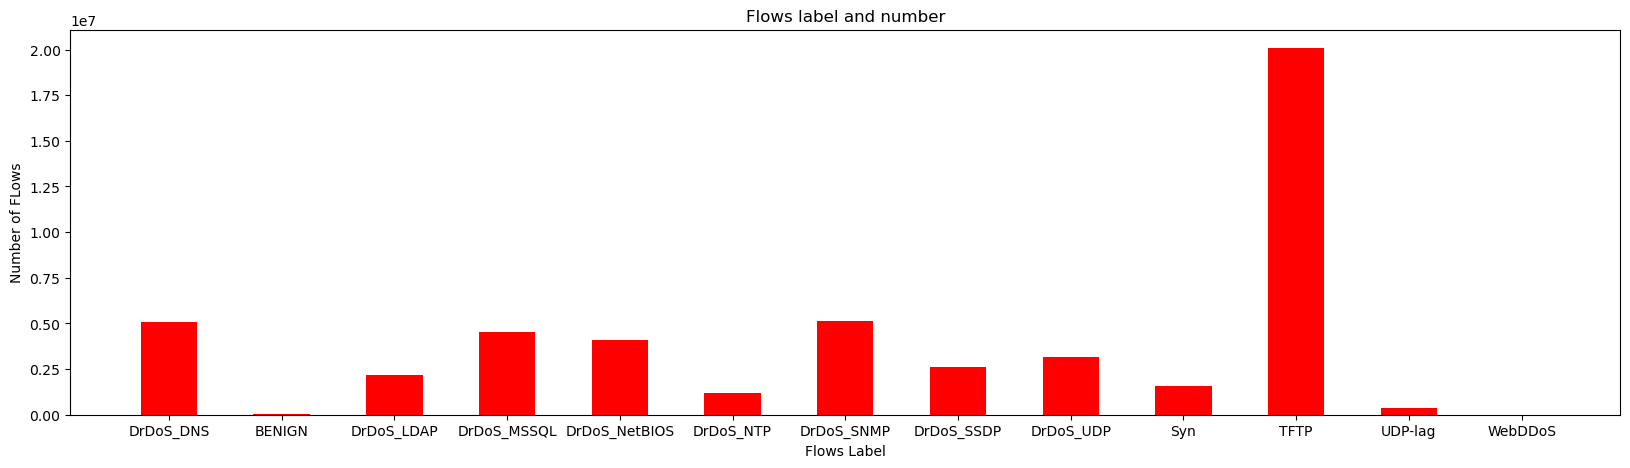

In [8]:
#Traing data plot
print('Training data plot')
data_plot(train)

In [9]:
#Testing data plot
#Traing data plot
#print('Testing data plot')
#data_plot(test)

In [10]:
# Get train and test labels count before drop NaN and inf
train_flow_labels_count = flows_labels_count(train)
#test_flow_labels_count = flows_labels_count(test)

In [11]:
# Drop NaN and inf
train = drop_NaN(train)
#test = drop_NaN(test)

In [12]:
# Get train and test labels count after drop NaN and inf
train_dropped_flow_labels_count = flows_labels_count(train)
#test_dropped_flow_labels_count = flows_labels_count(test)

In [13]:
# Get train dataset dropped labels number
for flow_label, flow_number in train_dropped_flow_labels_count.items():
    print('({}) Dropped train flow number is: {} ({:.2f}%)'.format(flow_label, -flow_number + train_flow_labels_count[flow_label], (-flow_number + train_flow_labels_count[flow_label])/flow_number*100))
# Get test dataset dropped labels number
#for flow_label, flow_number in test_dropped_flow_labels_count.items():
#    print('({}) Dropped test flow number is: {} ({:.2f}%)'.format(flow_label, -flow_number + test_flow_labels_count[flow_label], (-flow_number + test_flow_labels_count[flow_label])/flow_number*100))

(DrDoS_DNS) Dropped train flow number is: 162346 (3.31%)
(BENIGN) Dropped train flow number is: 438 (0.78%)
(DrDoS_LDAP) Dropped train flow number is: 38630 (1.80%)
(DrDoS_MSSQL) Dropped train flow number is: 126446 (2.88%)
(DrDoS_NetBIOS) Dropped train flow number is: 129833 (3.28%)
(DrDoS_NTP) Dropped train flow number is: 6952 (0.58%)
(DrDoS_SNMP) Dropped train flow number is: 10609 (0.21%)
(DrDoS_SSDP) Dropped train flow number is: 42042 (1.64%)
(DrDoS_UDP) Dropped train flow number is: 40643 (1.31%)
(Syn) Dropped train flow number is: 202306 (14.66%)
(TFTP) Dropped train flow number is: 566609 (2.90%)
(UDP-lag) Dropped train flow number is: 36382 (11.02%)
(WebDDoS) Dropped train flow number is: 0 (0.00%)


In [14]:
row_sample = train.iloc[0]
columns = list(train.columns)
for i, data in enumerate(row_sample):
    print(columns[i],':',data)

Unnamed: 0 : 425
Flow ID : 172.16.0.5-192.168.50.1-634-60495-17
Source IP : 172.16.0.5
Source Port : 634
Destination IP : 192.168.50.1
Destination Port : 60495
Protocol : 17
Timestamp : 2018-12-01 10:51:39.813448
Flow Duration : 28415
Total Fwd Packets : 97
Total Backward Packets : 0
Total Length of Fwd Packets : 42680.0
Total Length of Bwd Packets : 0.0
Fwd Packet Length Max : 440.0
Fwd Packet Length Min : 440.0
Fwd Packet Length Mean : 440.0
Fwd Packet Length Std : 0.0
Bwd Packet Length Max : 0.0
Bwd Packet Length Min : 0.0
Bwd Packet Length Mean : 0.0
Bwd Packet Length Std : 0.0
Flow Bytes/s : 1502023.5790955485
Flow Packets/s : 3413.689952489882
Flow IAT Mean : 295.98958333333337
Flow IAT Std : 500.95930068517794
Flow IAT Max : 3596.0
Flow IAT Min : 1.0
Fwd IAT Total : 28415.0
Fwd IAT Mean : 295.98958333333337
Fwd IAT Std : 500.95930068517794
Fwd IAT Max : 3596.0
Fwd IAT Min : 1.0
Bwd IAT Total : 0.0
Bwd IAT Mean : 0.0
Bwd IAT Std : 0.0
Bwd IAT Max : 0.0
Bwd IAT Min : 0.0
Fwd PSH F

In [15]:
# Encoding train dataset label
train = encoding_labels('train', train)
#test = encoding_labels('test', test)

In [16]:
# Drop num numberic columns ('Flow ID','Source IP','Destination IP', 'Timestamp', 'SimillarHTTP')
train = drop_non_numberic_columns(train)
#test = drop_non_numberic_columns(test)

In [17]:
print(train)

          Source Port  Destination Port  Protocol  Flow Duration  \
0                 634             60495        17          28415   
1                 634             60495        17              2   
2                 634             46391        17          48549   
3                 634             11894        17          48337   
4                 634             27878        17          32026   
...               ...               ...       ...            ...   
50063106        60489             27808         6              1   
50063107        60490             14102         6              1   
50063108        60491             58360         6              1   
50063109        60492              2905         6              2   
50063111        60494             44935         6            134   

          Total Fwd Packets  Total Backward Packets  \
0                        97                       0   
1                         2                       0   
2                 

In [18]:
#Shuffle data for training 
train = train.sample(frac=1)

(raylet) Spilled 3319 MiB, 9 objects, write throughput 993 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(raylet) Spilled 6898 MiB, 18 objects, write throughput 1297 MiB/s.
(raylet) Spilled 11292 MiB, 46 objects, write throughput 1076 MiB/s.


In [19]:
# Change data to numpy
train_day = train.to_numpy()
#test_day = test.to_numpy()

(raylet) Spilled 16653 MiB, 81 objects, write throughput 1075 MiB/s.
(raylet) Spilled 65721 MiB, 251 objects, write throughput 2429 MiB/s.
(raylet) Spilled 66222 MiB, 252 objects, write throughput 2381 MiB/s.
(raylet) [2023-07-17 14:17:27,637 E 1673960 1673973] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-07-17_14-09-28_263214_1660541 is over 95% full, available space: 13390778368; capacity: 269702828032. Object creation will fail if spilling is required.
(raylet) [2023-07-17 14:17:37,656 E 1673960 1673973] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-07-17_14-09-28_263214_1660541 is over 95% full, available space: 1237012480; capacity: 269702828032. Object creation will fail if spilling is required.
2023-07-17 14:17:41,927	WARNING worker.py:2019 -- Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1911, in ray._raylet.spill_objects_handler
  File "python/ray/_raylet.pyx", line 1914, in ray._raylet.spill_objects_handler
  File "/home/j

In [20]:
#np.savetxt('/disk2/jun/TrainCICIDS2019_np.csv', train_day, delimiter=',')

In [21]:
train_day_X = train_day[:, :81]
train_day_y = train_day[:, 81]
#test_day_X = test_day[:, :81]
#test_day_y = test_day[:, 81]

In [22]:
# Normalize data to range (0, 1)
scaler = MinMaxScaler()
scaler.fit(train_day_X)
train_normalized = scaler.transform(train_day_X)
#scaler.fit(test_day_X)
#train_normalized = scaler.transform(test_day_X)

In [65]:
# Slit training day data to train and test
X_train, X_val_test, y_train, y_val_test = train_test_split(train_day_X, train_day_y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.999, random_state=42) 

In [66]:
print('X_train shape: {}, y_train shape: {}'.format(X_train.shape, y_train.shape))
print('X_val shape: {}, y_val shape: {}'.format(X_val.shape, y_val.shape))
print('X_test shape: {}, y_test shape: {}'.format(X_test.shape, y_test.shape))

X_train shape: (38959900, 81), y_train shape: (38959900,)
X_val shape: (9739, 81), y_val shape: (9739,)
X_test shape: (9730237, 81), y_test shape: (9730237,)


In [ ]:
# Define Deeplearning parameters
batch_size = 100000
learning_rate = 0.005
num_epochs = 100

In [ ]:
# Custom dataset class
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.from_numpy(data)
        self.labels = torch.from_numpy(labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

Train_dataset = MyDataset(X_train.astype(np.float32), y_train.astype(np.float32))
Val_dataset = MyDataset(X_val.astype(np.float32), y_val.astype(np.float32))
Test_dataset = MyDataset(X_test.astype(np.float32), y_test.astype(np.float32))

# Create a data loader for batch training
train_loader = torch.utils.data.DataLoader(Train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(Val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(Test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Neural Model
# ANN (inputs_size = 81, 128, 256, 512, 256, 128, 13)
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(81, 128)
        self.l2 = nn.Linear(128, 256)
        self.l3 = nn.Linear(256, 512)
        self.l4 = nn.Linear(512, 256)
        self.l5 = nn.Linear(256, 128)
        self.l6 = nn.Linear(128, 13)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)
        
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.l4(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.l5(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.l6(out)
        return out

In [ ]:
def get_test_loss_acc(net, criterion, data_loader):
  """A simple function that iterates over `data_loader` to calculate the overall loss"""
  testing_loss = []
  testing_acc = []
  avg_loss = 0
  arg_acc = 0
  with torch.no_grad():
    for data in data_loader:
      inputs, labels = data
      # get the data to GPU (if available)
      inputs, labels = inputs.to(device), labels.to(device, dtype = torch.long) # Change to data type long to not rise error
      outputs = net(inputs)
      # calculate the loss for this batch
      loss = criterion(outputs, labels)
      # add the loss of this batch to the list
      testing_loss.append(loss.item())
      _, predicted = torch.max(outputs, 1) # Get prediction on batch (shape: batch_size)
      batch_correct_predicted = (predicted == labels).sum().item() # Get number of true prediction on batch
      testing_acc.append(batch_correct_predicted/batch_size*100) # Append prediction accuracy of this batch
  avg_loss = np.mean(testing_loss) 
  avg_acc = np.mean(testing_acc) 
      
  # calculate the average loss
  return {'loss': avg_loss, 'acc': avg_acc}

In [ ]:
model = NeuralNet()
model.to(device)

NeuralNet(
  (l1): Linear(in_features=81, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=256, bias=True)
  (l3): Linear(in_features=256, out_features=512, bias=True)
  (l4): Linear(in_features=512, out_features=256, bias=True)
  (l5): Linear(in_features=256, out_features=128, bias=True)
  (l6): Linear(in_features=128, out_features=13, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)

In [ ]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
writer = SummaryWriter()

In [ ]:
# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
f = open('/home/jun/CICIDS2019/ANN.csv', 'w')
writer = csv.writer(f)
header = ['10000 batch', 'train_loss', 'train_acc', 'test_loss', 'test_acc']
writer.writerow(header)


53

In [104]:
# Training loop
train_loss_d, train_acc_d, test_loss_d, test_acc_d = [], [], [], []
running_loss = []
running_acc = []
n_total_step = len(train_loader)
for epoch in range(num_epochs):
    # Total loss on all training sample
    total_loss = []
    # Total accuracy on all training sample
    total_acc = []
    for i, (data, labels) in enumerate(train_loader):
        # Batch size: 10000 
        # 1000000, 81
        labels = labels.to(device, dtype = torch.long) # Change labels to long data type for cross entropy
        data = data.to(device)
        
        # forward 
        outputs = model(data)
        loss = criterion(outputs, labels)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Batch loss
        running_loss.append(loss.item())

        # Batch accuracy calculate
        _, predicted = torch.max(outputs, 1) # Get prediction on batch (shape: batch_size)
        batch_correct_predicted = (predicted == labels).sum().item() # Get number of true prediction on batch
        running_acc.append(batch_correct_predicted/batch_size*100) # Append prediction accuracy 
        if i % 10 == 0:
            # Calculate average train loss on 10000 batch
            avg_train_loss = np.mean(running_loss)
            running_loss.clear()
            # Calculate average train accuracy on 10000 batch
            avg_train_acc = np.mean(running_acc)
            running_acc.clear()
            # Adding batch loss to total loss
            # Calculate average test loss on all val dataset
            #avg_test_loss = get_test_loss_acc(model, criterion, val_loader)['loss']
            # Calculate average train accuracy on all val dataset
            #avg_test_acc = get_test_loss_acc(model, criterion, val_loader)['acc']
            total_loss.append(avg_train_loss)
            # Adding batch accuracy to total accuracy
            total_acc.append(avg_train_acc)
            # Adding data to plot after training
            train_loss_d.append(avg_train_loss) 
            train_acc_d.append(avg_train_acc) 
            #test_loss_d.append(avg_test_loss) 
            #test_acc_d.append(avg_test_acc) 
            #print(f'epoch {epoch + 1}/{num_epochs}, step [{i+1}/{n_total_step}], train_loss = {avg_train_loss:.3f}, train_acc = {avg_train_acc:.3f}, test_loss = {avg_test_loss:.3f}, test_acc = {avg_test_acc:.3f}')
            print(f'epoch {epoch + 1}/{num_epochs}, step [{i+1}/{n_total_step}], train_loss = {avg_train_loss:.3f}, train_acc = {avg_train_acc:.3f}')
            # Write plot data to csv file
            #plot_data = [i+1,avg_train_loss,avg_train_acc,avg_test_loss,avg_test_acc]
            #writer.writerow(plot_data)
    scheduler.step()
    #print('Epoch: [{}/{}], train_Loss: {:.3f}, train_accuracy: {:.3f}'.format(epoch + 1, num_epochs, np.mean(total_loss), np.mean(total_acc)))
    #PATH = '/home/jun/CICIDS2019/saved_model/ANN_' + str(epoch+1) + 'epoch.pth'
    torch.save(model.state_dict(), PATH)

epoch 1/100, step [1/390], train_loss = 525596.000, train_acc = 6.987
epoch 1/100, step [2/390], train_loss = 112702.148, train_acc = 8.057
epoch 1/100, step [3/390], train_loss = 59288.746, train_acc = 7.681
epoch 1/100, step [4/390], train_loss = 15413.145, train_acc = 5.723
epoch 1/100, step [5/390], train_loss = 409.819, train_acc = 6.196
epoch 1/100, step [6/390], train_loss = 9.318, train_acc = 6.351
epoch 1/100, step [7/390], train_loss = 7.631, train_acc = 7.015
epoch 1/100, step [8/390], train_loss = 7.907, train_acc = 12.139
epoch 1/100, step [9/390], train_loss = 3.782, train_acc = 22.854
epoch 1/100, step [10/390], train_loss = 3.714, train_acc = 31.344
epoch 1/100, step [11/390], train_loss = 2.549, train_acc = 36.233
epoch 1/100, step [12/390], train_loss = 2.464, train_acc = 38.533
epoch 1/100, step [13/390], train_loss = 2.454, train_acc = 39.330
epoch 1/100, step [14/390], train_loss = 2.444, train_acc = 39.885
epoch 1/100, step [15/390], train_loss = 2.433, train_acc 